### I. Background & Goals

#### Task
Create a dataset in the form of a heat map representing the likelihood of finding a cobalt deposit at each point on the map

#### Parameters
- Assume that cobalt deposits are found in the presence of two different types of rock (serpentinite/ultramafic rock and granodiorite)
- The likelihood of cobalt occurring should fall off smoothly to zero where distance between the two rock types exceeds some distance (~10 km)
- Geological data stored in BedrockP.gpkg, CRS is EPSG:26910 (units in meters)

#### Deliverables
- A heat mapshowing the likelihood of finding cobalt at any specific location
- Some kind of data structure that allows us to query the likelihood of finding cobalt at any specific location
- Clear communication/documentation
- Clean, understandable code
- At least one unit test
- A README file with instructions for running your code along with a brief description of how you solved the problem



#### II. Load Data

In [ ]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os
from __future__ import annotations

# Set the working directory to the project root
project_root = Path().resolve().parent
os.chdir(project_root)

In [2]:
INPUT_FILE = "./data/raw/BedrockP.gpkg"
gdf = gpd.read_file(INPUT_FILE, engine="pyogrio")
gdf.head(2)

,gid,upid,area_m2,strat_unit,era,period,strat_age,strat_name,gp_suite,fm_lithodm,...,terrane,basin,basin_age,project,src_url,src_ref_s,map_comp,edit_date,pub_org,geometry
0,33649.0,9c192ffb,4368828.0,uKPCvl,Mesozoic,Cretaceous,Upper Cretaceous,Powell Creek Formation - upper unit,None,Powell Creek Formation,...,Overlap,None,None,Chilcotin-Bonaparte,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza et al., 1997, Chilcotin-Bonaparte, ...","Schiarizza, 2017, Chicotin-Bonaparte",2018-04-05,British Columbia Geological Survey,"POLYGON ((466212.803 5669781.240, 466385.735 5..."
1,26344.0,824df15e,34431394.0,lKGsv,Mesozoic,Cretaceous,Lower Cretaceous,Gambier Group,Gambier Group,None,...,Overlap,None,None,Mid-coast,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Bellefontaine et al., 1994, Mid-coast, BCGS, O...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((541326.012 5529535.059, 541118.840 5..."


#### Basic visualization

<AxesSubplot:>

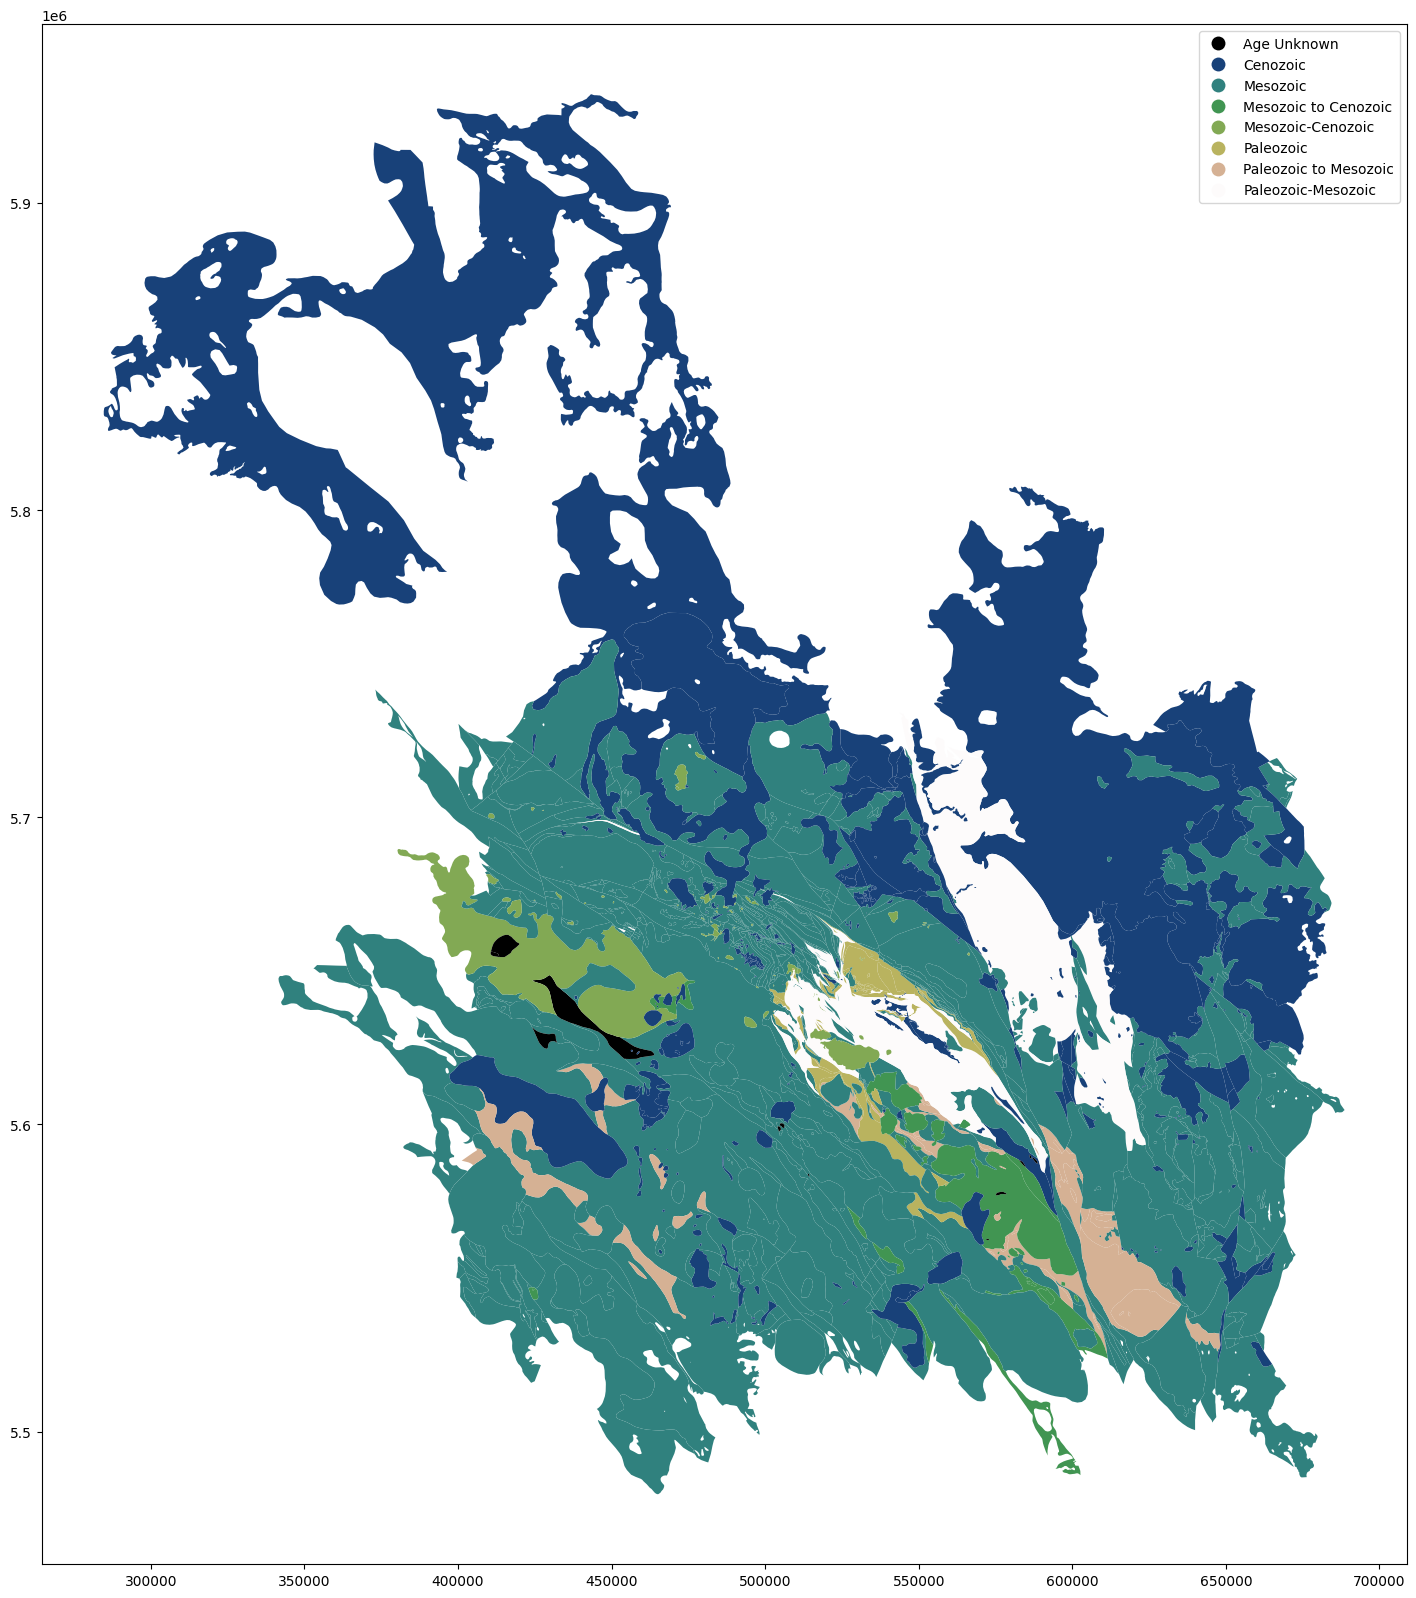

In [3]:
gdf.plot(column="era", categorical=True, legend=True, figsize=(20,20), cmap='gist_earth')

### III. Dataset exploration

In [4]:
# gdf.explore()

# Notes: 
#  - looks like geological data is stored across multiple columns

In [5]:
print(gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   gid         1596 non-null   float64 
 1   upid        1596 non-null   object  
 2   area_m2     1596 non-null   float64 
 3   strat_unit  1596 non-null   object  
 4   era         1596 non-null   object  
 5   period      1596 non-null   object  
 6   strat_age   1596 non-null   object  
 7   strat_name  1184 non-null   object  
 8   gp_suite    1036 non-null   object  
 9   fm_lithodm  443 non-null    object  
 10  mem_phase   76 non-null     object  
 11  rock_class  1596 non-null   object  
 12  rock_type   1596 non-null   object  
 13  rk_char     2 non-null      object  
 14  unit_desc   1596 non-null   object  
 15  age_max     1596 non-null   object  
 16  age_min     1596 non-null   object  
 17  belt        1596 non-null   object  
 18  terrane     1596 non-null   object  
 19

In [6]:
from prospectivity_tools.utils import df_more_info
df_info = df_more_info(gdf)
print(df_info)

Column: gid
  Missing: 0 (0.0%)
  Min: 1351.0, Max: 35327.0, Mean: 29576.919172932332


Column: upid
  Missing: 0 (0.0%)
  Unique values: 1596
  Examples:
    - 6606844a
    - 6d563880
    - 65d95e52
    - 5c9cc8bd
    - a3c686f1
    - 59c301f2
    - eef98990
    - 658f74b6
    - 9dbe7807
    - 2c49076e


Column: area_m2
  Missing: 0 (0.0%)
  Min: 9322.0, Max: 13439961396.0, Mean: 47946853.32393484


Column: strat_unit
  Missing: 0 (0.0%)
  Unique values: 205
  Examples:
    - uTrNsv
    - CJBRsv
    - CJBRsv
    - MmJBus
    - lKSB
    - CJBRsv
    - Ks
    - PiHoGv
    - EKAv
    - uTrTsc


Column: era
  Missing: 0 (0.0%)
  Unique values: 8
  Examples:
    - Mesozoic
    - Paleozoic-Mesozoic
    - Paleozoic-Mesozoic
    - Paleozoic to Mesozoic
    - Mesozoic
    - Paleozoic-Mesozoic
    - Mesozoic
    - Cenozoic
    - Cenozoic
    - Mesozoic


Column: period
  Missing: 0 (0.0%)
  Unique values: 19
  Examples:
    - Triassic
    - Carboniferous to Jurassic
    - Carboniferous to Juras

##### Some misc. notes
- rock_class contains an "ultramafic rock" category
- rock_type also contains "ultramafic rock" and "serpentinite"
- unit-desc may also be useful, as it contains "serpentinite" and "ultramafic rock" as well as "granodiorite"
- it may be useful looking at the literature to see if any of the other columns are potentially useful for this project

#### Quick LLM query
Before a lit search, let's query a LLM to see what additional insights can be gathered

In [7]:
import openai

client = openai.OpenAI()

prompt = f"""You are a geologist and a data scientist. 
You are given a geopandas dataframe with geological data, with the goal of finding cobalt. 
Here is a description of the dataset
{str(df_info)} 

Discuss your interpretation of these columns and how they might relate to finding cobalt,
particularly highlighting columns that may help identify the presence of ultramafic rocks,
serpentinite, and granodiorite. In the summary, highlight which specific columns may be
immediately useful towards this end.
Use regular line breaks in your response every 90 chars """

response = client.chat.completions.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": prompt}],
    temperature=0
)

print(response.choices[0].message.content)

To interpret the given dataset for the purpose of finding cobalt, it's essential to focus on  
geological features and rock types that are commonly associated with cobalt deposits. Cobalt  
is often found in association with ultramafic rocks, serpentinite, and sometimes granodiorite.  
Here's a breakdown of the relevant columns and their potential significance:

1. **rock_class**: This column is crucial as it categorizes the rocks into different classes.  
   The presence of "ultramafic rocks" is particularly important because ultramafic rocks  
   are known to host cobalt deposits. The dataset contains 46 entries of ultramafic rocks,  
   which should be prioritized for further investigation.

2. **rock_type**: This column provides more detailed information about the rock types.  
   Look for entries mentioning "serpentinite" or "ultramafic" as these are directly  
   associated with cobalt mineralization. The presence of "serpentinite ultramafic rocks"  
   is a strong indicator of p

##### Thoughts:
 - Looking at the info above, the LLM agrees that rock_class, rock_type, and unit_desc are potentially the most directly useful columns
 - Looking at the other potentially useful columns mentioned, "era", "period", "strat_age", "belt,", and "terrane" may provide context for a more complex model, which is not what we're building here. "strat_unit", however, merits some investigation
 - [This 2013 publication]("https://cdn.geosciencebc.com/project_data/GBC_Report2013-13/GBC_Report2013-13.pdf") by an independent BC geoscience research group decodes the strat_unit variable
 - Here we are looking for the rock code/lithology, which comes near the end of the strat_unit classification. This publication suggests gd is granodiorite, us is serpentinite ultramaphic, and um is ultramafic
 - [This official government of BC publication]("https://cmscontent.nrs.gov.bc.ca/geoscience/PublicationCatalogue/OpenFile/BCGS_OF2017-08.pdf") provides a nice overview of the dataset, including some additional information on strat_unit. My best understanding is that strat_unit consists of:
     ```
     [age][optional named unit][lithology/rock code].[extra characteristics]
     ```

#### Full Variable Descriptions ([Same source as above]("https://cmscontent.nrs.gov.bc.ca/geoscience/PublicationCatalogue/OpenFile/BCGS_OF2017-08.pdf"))

| Attribute | Description |
|-----------|-------------|
| **upid** | Unique ID for bedrock polygons |
| **strat_unit** | Recommended geological unit code in standard label format consisting of age/position at Epoch level, named lithostratigraphic or lithodemic unit, lithology, and other characteristics, e.g., uTrBPvb.fx: Upper Triassic Bonanza Group - Parson Bay Formation – basalt as flow with megacryst |
| **area_m2** | Area size of a bedrock unit polygon in square metres |
| **era** | Geological Era within which the unit lies |
| **period** | Geological Period within which the unit lies |
| **strat_age** | Stratigraphic age or age range of unit |
| **strat_name** | Stratigraphic name of unit |
| **gp_suite** | Supergroup, group, subgroup, and equivalent ranks |
| **fm_lithodm** | Formation, lithodeme and equivalent rank |
| **mem_phase** | Subdivision of unit at member, phase, bed, flow, facies, and other equivalent ranks |
| **rock_class** | Main lithology classes: intrusive, volcanic, sedimentary, metamorphic, ultramafic |
| **rock_type** | Generalized to specific lithological name or description |
| **rk_char** | Distinct characteristics of bedrock unit or lithology: mineralogy, texture/fabric (grain sizes, pillowed, columns, flow), structure (e.g., schistose and gneissic), colours, alteration, weathering, and environment |
| **unit_desc** | Original description of the unit from map compilation |
| **age_max** | Maximum age of unit (for numerical age, visit http://www.stratigraphy.org) |
| **age_min** | Minimum age of unit (for numerical age, visit http://www.stratigraphy.org) |
| **belt** | Morphotectonic belt |
| **terrane** | Name of tectono-stratigraphic terrane |
| **basin** | Name of sedimentary basin |
| **basin_age** | Age of basin |
| **Project** | Project name of regional map compilation |
| **map_comp** | Map compilation reference: author(s), year, and named project or area |
| **src_ref_s** | Short reference to source data of map compilation: author(s), year, project or area, organization, and publication number: e.g., Schiarizza et al., 2013, Chilcotin-Bonaparte, BCGS, Open File 2013-5 |
| **src_url** | URL to source data of map compilation |
| **edit_date** | Publication date of a data edition |
| **pub_org** | Organization of data publication: British Columbia Geological Survey |

In [8]:
# Now, Let's do a full investigation of strat_unit
gdf['strat_unit'].unique()

array(['uKPCvl', 'lKGsv', 'JKCsf', 'Mivb', 'lmJLs', 'JKRMTMs', 'uTrNC',
       'muJRMTPs', 'Pefp', 'lKTCPs', 'CJBRsv', 'lKTCLs', 'EMRgd', 'PSHSM',
       'LJKqd', 'LJqd', 'uTrNE', 'EKATsf', 'MKgr', 'PBEus', 'JKCs',
       'MmJBsv', 'lKJ', 'mJKsc', 'PTrMgd', 'LTrJGH', 'LTrJGBe', 'EKAv',
       'LTrJIC', 'PCh', 'uTrCgs', 'uTrCHsc', 'uTrCv', 'lKJMs', 'lKJMLs',
       'LKAMqd', 'KTCBCs', 'MmJBum', 'LTrJGBo', 'Kgd', 'LKqd', 'LJKgd',
       'MKgd', 'PzMzog', 'lmJBwst', 'MKqd', 'LJKP', 'LKTgd', 'LTrJGB',
       'Efp', 'EKdr', 'lKTCDs', 'LKEdr', 'lKTCca', 'lKRMPRsf', 'KTmm',
       'CJBRus', 'PTrMdr', 'Mivf', 'lKGP', 'PBELum', 'uTrTsc', 'JKCsc',
       'lmJLa', '?dr', 'KP', 'LTrJum', 'lmJLaD', 'JKCe', 'JKsf', 'Egd',
       'luKSQcg', 'Migd', 'LJKdr', 'PiHoGvb', 'lKTCFRvs', 'lKTRca',
       'Miqd', 'MmJBus', 'PTrMml', 'ETgd', 'MzS', 'lKTRs', 'EJdr',
       'uTrNsvc', 'lmJA', 'Evd', 'PBELgb', 'CTrBRbs', 'uTrN', 'PnlJCCsv',
       'Miqm', 'MKdr', 'LKgd', 'LTrJGG', 'LTrJgd', 'uTrNW', 'EPrb',
     

#### Thoughts (cont'd)
- Looking at the values, it appears that the rock code is two lower-case letters at the end, before a period if applicable.
- I think we can use this to extract the rock code
- Let's try the approach of using extracted rock code from strat_unit, rock_class, rock_type, and unit_desc to fully capture serpentinite/ultramafic rock and granodiorite
- Once we create these binary classifiers per variable, we can compare and look at the overlap

### IV. Preliminary Feature Engineering

Goal: Create binary classifiers for serpentinite/ultramafic rock and granodiorite based on the strat_unit (method 1), rock_class (method 2), rock_type (method 3), and unit_desc (method 4) columns

In [9]:
# METHOD 1: strat_unit

def parse_strat_unit(code: str):
    """
    Extracts rock_code from a strat_unit code.
    Assumes:
      - lithology code is last 2 lowercase letters before optional .suffixes
      - optional suffixes follow after dot(s), e.g., '.fx', '.l'
    """
    # Split off the suffixes first
    parts = code.split(".")
    core = parts[0]          # everything before first dot


    # Get last two letters of the core part as rock_code
    rock_code = core[-2:] if len(core) >= 2 else None
    return rock_code

gdf['is_ultramafic_meth1'] = gdf['strat_unit'].apply(lambda x: parse_strat_unit(x) in ['us', 'um'])
gdf['is_granodiorite_meth1'] = gdf['strat_unit'].apply(lambda x: parse_strat_unit(x) == 'gd')

In [10]:
# METHOD 2: rock_class (can only categorize ultramafic this way)
gdf['is_ultramafic_meth2'] = gdf['rock_class'].apply(lambda x: x == 'ultramafic rocks')

In [11]:
# METHOD 3: rock_type
# text contains ultramafic or serpentinite (any case)
gdf['is_ultramafic_meth3'] = gdf['rock_type'].str.contains('ultramafic|serpentinite', case=False, na=False)
gdf['is_granodiorite_meth3'] = gdf['rock_type'].str.contains('granodiorite', case=False, na=False)

In [12]:
# METHOD 4: unit_desc
# text contains ultramafic or serpentinite (any case)
gdf['is_ultramafic_meth4'] = gdf['unit_desc'].str.contains('ultramafic|serpentinite', case=False, na=False)
gdf['is_granodiorite_meth4'] = gdf['unit_desc'].str.contains('granodiorite', case=False, na=False)

In [13]:
# Full comparison of the 4 methods
# Create a count of the different permutations of the methods
methods = ['is_ultramafic_meth1', 'is_ultramafic_meth2', 'is_ultramafic_meth3', 'is_ultramafic_meth4',
           'is_granodiorite_meth1', 'is_granodiorite_meth3', 'is_granodiorite_meth4']
method_counts = gdf[methods].apply(lambda x: tuple(x), axis=1).value_counts()

# Format as a dataframe, splitting methods into columns named from 'methods' string list
method_df = pd.DataFrame(method_counts).reset_index()
method_df.columns = ['methods', 'count']
method_df[methods] = pd.DataFrame(method_df['methods'].tolist(), index=method_df.index)
method_df = method_df.drop(columns=['methods'])
method_df

,count,is_ultramafic_meth1,is_ultramafic_meth2,is_ultramafic_meth3,is_ultramafic_meth4,is_granodiorite_meth1,is_granodiorite_meth3,is_granodiorite_meth4
0,1128,False,False,False,False,False,False,False
1,129,False,False,False,False,True,False,True
2,127,False,False,False,True,False,False,False
3,124,False,False,False,False,False,False,True
4,37,True,False,True,True,False,False,False
5,22,False,True,True,True,False,False,False
6,21,True,True,True,True,False,False,False
7,5,False,False,True,False,False,False,False
8,3,True,True,True,False,False,False,False


#### Thoughts
- There are no occurances of ultramafic and granodiorite in the same row by any method, which is encouraging
- Method 1 isn't necessary, as all ultramafic and granodiorite classifications via that method were also caught by at least one method. This is encouraging, but since it's the method I feel shakiest about, it is also nice that we can drop it
- I don't love how many classifications are made by method 4 (unit description) alone. Let's take a close look at that column just to make sure we don't have hits like ("no serpentinite here") or ("granodiorite not present") that would skew our results

In [14]:
for i in (gdf[gdf['is_ultramafic_meth4']].unit_desc.unique()):
    print("-",i)

- Ribbon chert, argillite and pillowed to massive basalt, with lesser amounts of limestone, gabbro, diabase, serpentinite, siltstone, sandstone, pebble conglomerate, slate, phyllite and quartz phyllite
- Serpentinite, commonly with knockers of ultramafic rock, gabbro, diorite, diabase, amphibolite, basalt, sandstone, pebble conglomerate, limestone, chert; local talc schist, listwanite, rodingite
- Serpentinite, harzburgite, dunite, wehrlite, clinopyroxenite, gabbro, diorite, quartz diorite, soda granite, diabase, pillowed to massive greenstone and greenstone breccia; minor amounts of limestone and chert
- Undivided ribbon chert, argillite, phyllite, quartz phyllite and pillowed to massive greenstone, with lesser amounts of limestone, gabbro, diabase, serpentinite, sandstone and pebble conglomerate; locally includes minor amounts of Cayoosh Assembla
- Strongly imbricated MJBR together with fault slivers of ultramafic rock and Cayoosh assemblage
- Garnet-biotite, staurolite, kyanite and 

In [15]:
for i in (gdf[gdf['is_granodiorite_meth4']].unit_desc.unique()):
    print("-",i)

- Hornblende-biotite-plagioclase-quartz porphyry; hornblende-biotite-plagioclase porphyry; local quartz diorite, diorite, granodiorite
- Medium to coarse-grained biotite-hornblende granodiorite
- Quartz diorite, variably foliated; lesser granodiorite; includes minor gneissic diorite and inclusions and screens of other rock types; includes Burnett Bay and Lillooet River Intrusion
- Granodiorite
- Granodiorite; minor quartz diorite
- Granodiorite and slightly younger porphyry dikes and plugs
- Hornblende quartz diorite, hornblende diorite, hornblende-plagioclase porphyry; rare granodiorite
- Quartz diorite to granodiorite; minor diorite
- Granodiorite; lesser quartz diorite and quartz monzonite
- Quartz diorite; lesser granodiorite
- Variably foliated granodiorite; lesser quartz diorite; includes Fish Egg, Smith Inlet, Belize Inlet, Draney Inlet, Sandell, McFee Bay, Rivers Inlet, Amback, Kwatna, Doos Creek, Kingcome, Namu, Big Julie, Castle Towers, Meslillooet, Pinecone, Vicke
- Variably

#### Thoughts/classification conclusion
- It does appear on a close read-through that every classification made by method 4 (unit description) is valid, with no obvious false positives (NB for a larger dataset, this would be a good use of an LLM call)
- Since method 1 is redundant, we can drop it
- For our classification script, we can combine the strings of rock_type, rock_class, and unit_desc to create a single column that contains all of the information we need


### V. Brief Literature Search

#### Questions:
1) What methods are used in the literature to classify cobalt prospectivity?
2) What additional columns in the dataset may be useful for this project?
3) If cobalt is between two rock types, should they treated with equal weight?

#### Answers:

Question 1:
- I was able to find a recent paper (Nykänen, Törmänen, & Niiranen 2023) that uses a concept (new to me) called "fuzzy logic overlay" to classify prospectivity (and Cobalt in particular), which appears to be directly relevant to this project [1]
- Fuzzy sets were introduced in 1965 by a set theory mathematicion, Zadeh [2]
- The use of the fuzzy logic method for prospectivity analysis goes back at least to the 80s, with Bonham-Carter (1996) detailing the method in a book chapter [3]
- It appears that fuzzy logic overlay combines multiple layers of data, each with a degree of certainty, to create a composite map of prospectivity [2]. This is similar to the heat map we are trying to create, where we have information about proximity to ultramafic rock/serpentinite and proximity to granodiority, and wish to classify the likelihood of finding cobalt at any given point on the map
- This answers one question I have been considering, which is, "what is the scale?" If we are using fuzzy logic overlay, then we can use a continuous scale of 0-1 for likelihood of finding cobalt
- A second question I have been asking is, how to combine the knowledge about the distance to the two rock types? Per the fuzzy logic overlay method, operators appear to be "Fuzzy AND", "Fuzzy OR", and "Fuzzy gamma," which are strung together in complex sequences depending on the mineral problem to be solved [1]
- Other state-of-the-art methods for prospectivity mapping include machine learning algorithms such as random forest and logistic regression and AI-driven models [1], though these are less relevant for this particular work

Question 2:
- The concept of "fuzzy logic overlay", suggests that we can use any number of columns in the dataset to create a prospectivity map, so long as they are relevant to the mineral in question, and gives us a mathematical framework for combining them
- Given the limited scope of this project, we will focus on the direct presence and absence of the two rock types

Question 3:
- My initial read of the literature suggests that it is not necessary to treat the two rock types with equal weight
- Therefore, my model should have the ability to assign different weights, even if I initially set them equal
- I believe this would be characterized as "fuzzy AND" in the fuzzy logic overlay method, as the instructions stated the presence of both rock types is necessary for cobalt prospectivity


[1] Nykänen, V., Törmänen, T. & Niiranen, T. Cobalt Prospectivity Using a Conceptual Fuzzy Logic Overlay Method Enhanced with the Mineral Systems Approach. Nat Resour Res 32, 2387–2416 (2023). https://doi.org/10.1007/s11053-023-10255-8

[2] L.A. Zadeh, Fuzzy sets, Information and Control, 8 (1965) 338-353.

[3] Bonham-Carter , G. F. 1994 . Geographic Information Systems for Geoscientists – Modelling with GIS , New York : Pergamon Press . (Computer Methods in the Geosciences)
